<a href="https://colab.research.google.com/github/vijayj8v11/memristor/blob/main/memristorMVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 469kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNN().to(device)


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    return total_loss / len(train_loader.dataset), 100. * correct / len(train_loader.dataset)

def evaluate(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return total_loss / len(test_loader.dataset), 100. * correct / len(test_loader.dataset)


In [ ]:

num_epochs = 10
train_losses, train_acc = [], []
test_losses, test_acc = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
    test_loss, test_accuracy = evaluate(model, device, test_loader)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    print(f"Epoch {epoch} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")


Epoch 1 - Train Acc: 95.25% - Test Acc: 98.61%
Epoch 2 - Train Acc: 98.33% - Test Acc: 98.73%
Epoch 3 - Train Acc: 98.77% - Test Acc: 99.16%
Epoch 4 - Train Acc: 99.00% - Test Acc: 99.14%
Epoch 5 - Train Acc: 99.24% - Test Acc: 99.16%
Epoch 6 - Train Acc: 99.28% - Test Acc: 99.08%
Epoch 7 - Train Acc: 99.44% - Test Acc: 99.12%
Epoch 8 - Train Acc: 99.49% - Test Acc: 99.22%
Epoch 9 - Train Acc: 99.53% - Test Acc: 99.12%
Epoch 10 - Train Acc: 99.60% - Test Acc: 99.32%


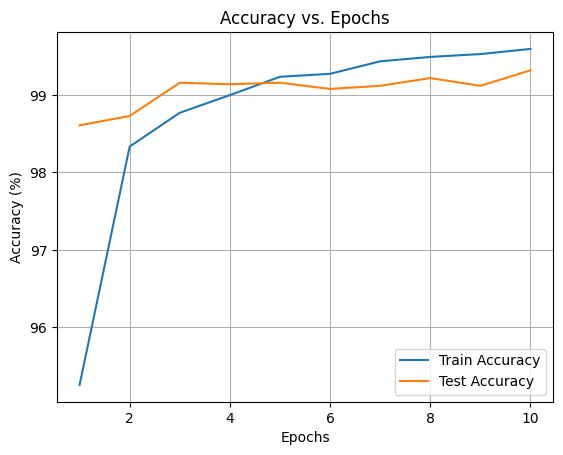

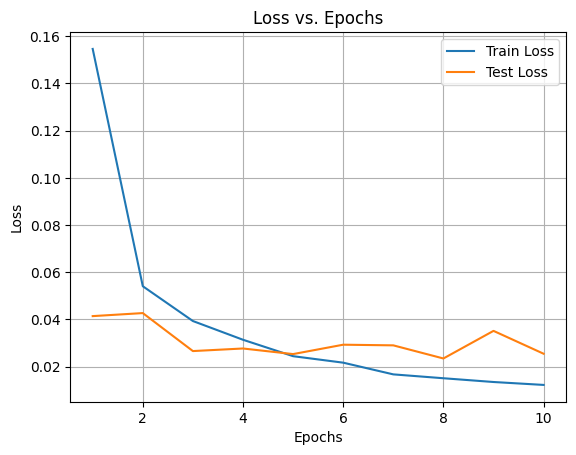

In [ ]:

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, test_acc, label="Test Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


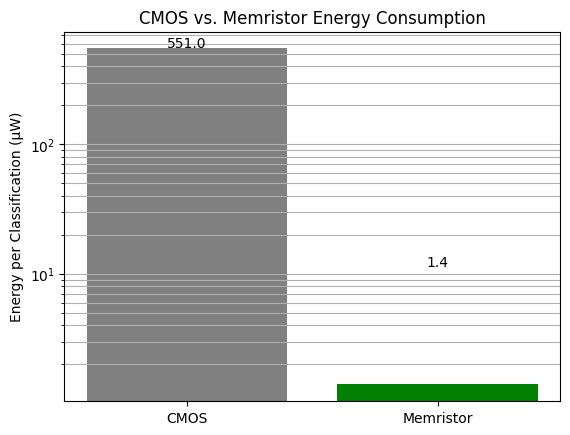

In [ ]:

energy_cmos = 551.0      # in microWatts
energy_memristor = 1.4   # in microWatts

labels = ['CMOS', 'Memristor']
values = [energy_cmos, energy_memristor]

plt.figure()
bars = plt.bar(labels, values, color=['gray', 'green'])
plt.yscale('log')
plt.ylabel("Energy per Classification (μW)")
plt.title("CMOS vs. Memristor Energy Consumption")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 10, f"{yval:.1f}", ha='center')
plt.grid(True, which='both', axis='y')
plt.show()


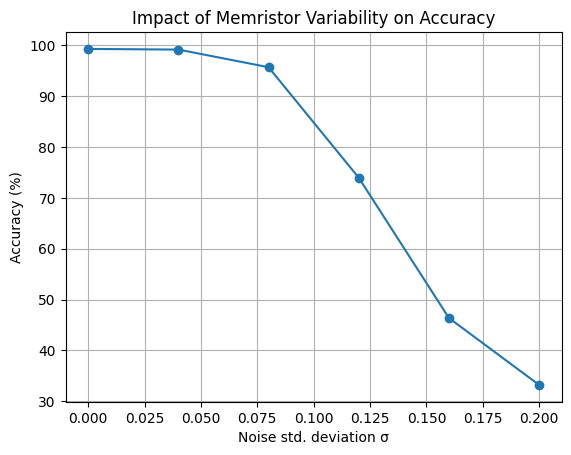

In [ ]:

def accuracy_with_noise(model, sigma):
    noisy_model = copy.deepcopy(model)
    with torch.no_grad():
        for param in noisy_model.parameters():
            param.add_(torch.randn_like(param) * sigma)
    _, acc = evaluate(noisy_model, device, test_loader)
    return acc

sigmas = np.linspace(0.0, 0.2, 6)
accuracy_drop = [accuracy_with_noise(model, s) for s in sigmas]

plt.figure()
plt.plot(sigmas, accuracy_drop, 'o-')
plt.title("Impact of Memristor Variability on Accuracy")
plt.xlabel("Noise std. deviation σ")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()
